In [47]:
import numpy as np
import pandas as pd
import xarray as xr
from odc.geo.xr import ODCExtensionDa
from odc.geo import GeoboxTiles
import matplotlib.pyplot as plt

In [50]:
i = 5; j = 10

# Load data
parquet_tile = pd.read_parquet(f"/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/modis.parquet/ix={i}/iy={j}/data.parquet")
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated = False).odc.assign_crs(4326)
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr", consolidated = False).odc.assign_crs(4326)

# Create tiles
tile_size = (2048, 2048)
tile = GeoboxTiles(land_mask.odc.geobox, tile_size)[i,j]

# Add pixel ID information for tile
pixel_id_matrix = xr.DataArray(np.flip(np.arange(tile_size[0] * tile_size[1], dtype="int32").reshape(tile_size), 0), name = 'pixel_id')

In [54]:
modis_subset = modis["median"].odc.crop(tile.footprint(4326)).compute()
land_mask_subset = land_mask["land_mask"].odc.crop(tile.footprint(4326)).compute()

In [36]:
modis_subset_time = modis_subset.isel(time=0)

In [43]:
test = ((modis_subset_time > modis_subset_time.quantile(.99)) | (modis_subset_time < modis_subset_time.quantile(.01)))

In [69]:
modis_subset_time.quantile(.75)

<xarray.DataArray 'median' ()> Size: 8B
array(294.89)
Coordinates:
    quantile  float64 8B 0.75

In [68]:
modis_subset_time.max()

<xarray.DataArray 'median' ()> Size: 8B
array(306.)
Coordinates:
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2000-12-31

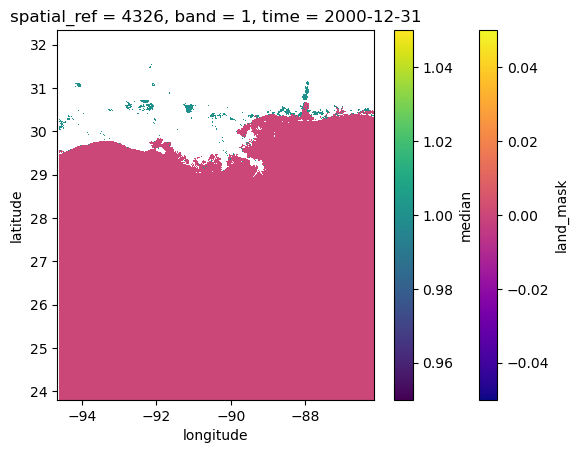

In [ ]:
fig, ax = plt.subplots()

land_mask_subset.where(land_mask_subset==0).squeeze().plot.imshow(ax=ax, cmap="plasma")
test.where(test==1).squeeze().plot.imshow(ax=ax)

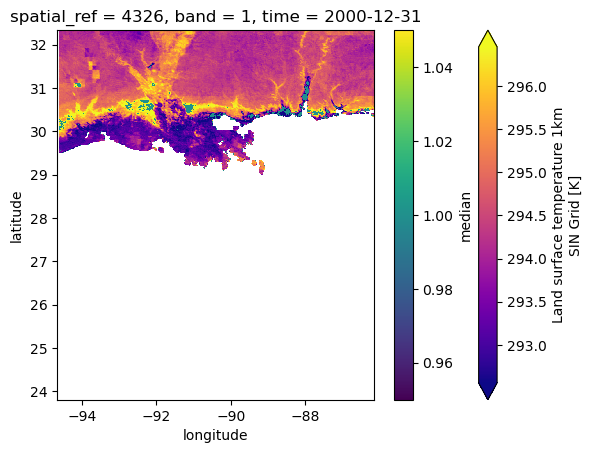

In [67]:
fig, ax = plt.subplots()

modis_subset_time.squeeze().plot.imshow(ax=ax, cmap="plasma", robust=True)
test.where(test==1).squeeze().plot.imshow(ax=ax)

In [11]:
parquet_tile["median"].quantile(.01)

np.float64(290.85)

In [10]:
parquet_tile["median"].quantile(.99)

np.float64(295.46)

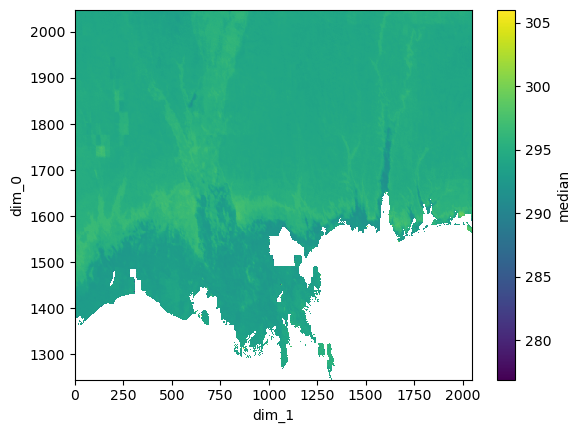

In [5]:
pd.merge(
    parquet_tile.query("year==2000&median>0")[["pixel_id", "median"]], 
    pixel_id_matrix.to_dataframe().reset_index()).set_index(["dim_0", "dim_1"]).to_xarray()["median"].plot.imshow()

<Axes: >

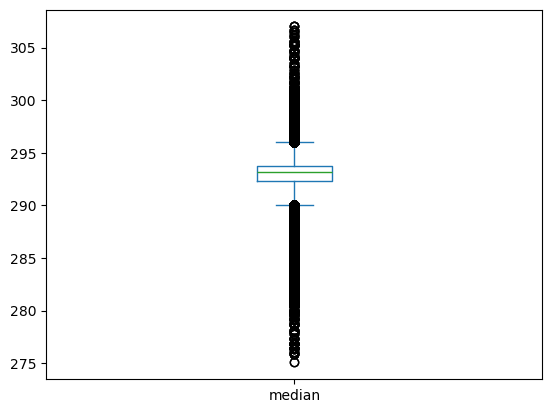

In [7]:
parquet_tile["median"].plot(kind="box")